notes : 
- trouver comment exploiter le "superuser"

## Ajout autres features

Nous n’avons volontairement pas concaténé l’ensemble des avis d’un restaurant afin d’éviter un biais de volume lié au nombre d’avis. Nous prenons 40 avis par restaurant ce qui correspond à la mediane du nombre d'avis par restaurant. Nous prenons les 40 avis les plus recents pour avoir l'information la plus a jour.

In [254]:
import pandas as pd
import json
data = []
with open("data/philly_restaurant_reviews.json", "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))
textes=pd.DataFrame(data)

# nombre d'avis par business
nb_avis = textes.groupby("business_id").size()

nb_avis.describe()
# s'assurer que la colonne date est bien au format datetime
textes["date"] = pd.to_datetime(textes["date"])

textes_restaurant = (
    textes
    .sort_values("date", ascending=False)   # du plus récent au plus ancien
    .groupby("business_id")
    .head(40)                                # garder les 40 plus récents
    .groupby("business_id", as_index=False)["text"]
    .apply(" ".join)
)

textes_restaurant.head()


,business_id,text
0,-0M0b-XhtFagyLmsBtOe8w,Ok so this place is an extremely odd hole in t...
1,-0PN_KFPtbnLQZEeb23XiA,Far and away the best Chinese food to order if...
2,-0TffRSXXIlBYVbb5AwfTg,I went to indieblue a few years ago for happy ...
3,-0eUa8TsXFFy0FCxHYmrjg,"We are sitting in an ICU waiting room, several..."
4,-1B9pP_CrRBJYPICE5WbRA,The food is absolutely amazing. I get food ...


In [255]:
photos = pd.read_csv('embeddings_by_business.csv')
photos.rename(columns={'gbusiness_id':'business_id'}, inplace=True)
df=pd.merge(photos, textes_restaurant, on='business_id', how='outer')
df.rename(columns={'embedding':'image_embedding'}, inplace=True)


In [256]:
# Étape 1: Convertir les strings en vecteurs numériques
def convert_embeddings(embeddings_strings):
    """
    Convertit un array de strings d'embeddings en array numérique 2D
    Les embeddings 'nan' sont gardés comme vecteurs de NaN
    """
    embeddings_list = []
    embedding_dim = None
    
    # Premier passage pour déterminer la dimension
    for emb_str in embeddings_strings:
        if isinstance(emb_str, np.ndarray):
            emb_str = emb_str[0]
        
        if emb_str != 'nan' and emb_str != 'None':
            try:
                emb_str_clean = emb_str.strip('[]')
                emb_array = np.fromstring(emb_str_clean, sep=' ')
                embedding_dim = len(emb_array)
                break
            except:
                continue
    
    if embedding_dim is None:
        raise ValueError("Impossible de déterminer la dimension des embeddings")
    
    print(f"✓ Dimension des embeddings: {embedding_dim}")
    
    # Deuxième passage pour convertir tous les embeddings
    for i, emb_str in enumerate(embeddings_strings):
        # Extraire la string (elle est dans un array de shape (1,))
        if isinstance(emb_str, np.ndarray):
            emb_str = emb_str[0]
        
        # Si c'est nan, créer un vecteur de NaN
        if emb_str == 'nan' or emb_str == 'None':
            nan_vector = np.full(embedding_dim, np.nan)
            embeddings_list.append(nan_vector)
            continue
        
        try:
            # Nettoyer la string et convertir en array
            emb_str_clean = emb_str.strip('[]')
            emb_array = np.fromstring(emb_str_clean, sep=' ')
            embeddings_list.append(emb_array)
        except Exception as e:
            print(f"⚠️ Erreur pour l'embedding {i}: {e} - remplacé par NaN")
            nan_vector = np.full(embedding_dim, np.nan)
            embeddings_list.append(nan_vector)
    
    # Convertir en array NumPy 2D
    embeddings_2d = np.array(embeddings_list)
    
    # Compter les NaN
    n_nan = np.isnan(embeddings_2d).any(axis=1).sum()
    print(f"✓ {n_nan} embeddings avec NaN gardés")
    
    return embeddings_2d
image_embedding = convert_embeddings(df['image_embedding'].tolist())

✓ Dimension des embeddings: 512
⚠️ Erreur pour l'embedding 1: 'float' object has no attribute 'strip' - remplacé par NaN
⚠️ Erreur pour l'embedding 8: 'float' object has no attribute 'strip' - remplacé par NaN
⚠️ Erreur pour l'embedding 10: 'float' object has no attribute 'strip' - remplacé par NaN
⚠️ Erreur pour l'embedding 11: 'float' object has no attribute 'strip' - remplacé par NaN
⚠️ Erreur pour l'embedding 12: 'float' object has no attribute 'strip' - remplacé par NaN
⚠️ Erreur pour l'embedding 14: 'float' object has no attribute 'strip' - remplacé par NaN
⚠️ Erreur pour l'embedding 16: 'float' object has no attribute 'strip' - remplacé par NaN
⚠️ Erreur pour l'embedding 20: 'float' object has no attribute 'strip' - remplacé par NaN
⚠️ Erreur pour l'embedding 21: 'float' object has no attribute 'strip' - remplacé par NaN
⚠️ Erreur pour l'embedding 22: 'float' object has no attribute 'strip' - remplacé par NaN
⚠️ Erreur pour l'embedding 23: 'float' object has no attribute 'strip'

In [257]:
image_embedding.shape

(5852, 512)

In [258]:
features=pd.read_csv('restaurant_features.csv')

In [259]:
df=pd.merge(df, features, on='business_id', how='outer')

In [260]:
df

,business_id,image_embedding,n_labels,labels_present,text,n_reviews,avg_stars,std_stars,first_review_x,last_review_x,...,attributes,categories,hours,latitude_y,longitude_y,review_count_y,restaurants_within_500m,avg_neighbor_review_count,relative_review_intensity,distance_to_center_km
0,-0M0b-XhtFagyLmsBtOe8w,[ 9.81536725e-03 -1.35909736e-03 1.12843779e-...,1.0,inside,Ok so this place is an extremely odd hole in t...,18,3.722222,0.894792,2012-02-10 04:00:49,2018-05-13 04:00:27,...,"{'Alcohol': ""u'full_bar'"", 'OutdoorSeating': '...","Bars, Nightlife, Restaurants, French, Wine Bars","{'Thursday': '17:0-0:0', 'Friday': '17:0-0:0',...",39.967439,-75.175452,18,47,173.708333,0.103622,1.993035
1,-0PN_KFPtbnLQZEeb23XiA,NaN,NaN,NaN,Far and away the best Chinese food to order if...,11,3.363636,1.361817,2009-10-16 15:24:48,2016-04-15 21:44:07,...,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","Restaurants, Chinese","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",39.923048,-75.178078,9,46,57.893617,0.155458,6.095792
2,-0TffRSXXIlBYVbb5AwfTg,[-2.06359725e-03 2.78890153e-02 9.09338878e-...,4.0,"drink, food, inside, outside",I went to indieblue a few years ago for happy ...,1132,4.355124,0.983165,2013-06-01 01:47:50,2022-01-18 18:56:27,...,"{'RestaurantsReservations': 'True', 'NoiseLeve...","Cocktail Bars, Food Delivery Services, Nightli...","{'Monday': '0:0-0:0', 'Tuesday': '16:0-22:0', ...",39.948508,-75.161969,1097,450,210.201774,5.218795,2.991351
3,-0eUa8TsXFFy0FCxHYmrjg,[ 3.80490937e-02 -7.54836206e-04 8.75527248e-...,1.0,food,"We are sitting in an ICU waiting room, several...",28,3.964286,1.070899,2015-10-20 18:20:03,2019-09-14 17:35:02,...,"{'BikeParking': 'True', 'RestaurantsGoodForGro...","Caterers, Sandwiches, Delis, Restaurants, Cafe...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",39.952446,-75.187321,26,66,91.746269,0.283390,3.764602
4,-1B9pP_CrRBJYPICE5WbRA,[-2.49907263e-02 3.30465585e-02 3.43133989e-...,2.0,"food, inside",The food is absolutely amazing. I get food ...,851,3.808461,1.205760,2012-07-18 02:37:42,2022-01-16 19:38:30,...,"{'RestaurantsGoodForGroups': 'True', 'WiFi': ""...","Asian Fusion, Restaurants, American (New), Tha...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:30...",39.950352,-75.161583,822,488,219.656442,3.742208,2.784421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,zxY4DgtXsVHihSUpsmwamg,NaN,NaN,NaN,This Place has Good Hoagies and the Staff is s...,6,4.333333,0.516398,2012-05-06 22:52:29,2019-10-02 02:55:18,...,"{'RestaurantsTakeOut': 'True', 'GoodForKids': ...","Food, Do-It-Yourself Food, Restaurants, Italian",NaN,39.928473,-75.161983,6,96,126.979381,0.047252,5.183790
5848,zy7uNOvpykrq-XlmDY_wHA,NaN,NaN,NaN,"Sadiki's is now Relish, nothing last's over th...",6,3.166667,0.983192,2008-01-19 20:59:57,2009-06-08 22:26:57,...,"{'GoodForKids': 'True', 'BusinessAcceptsCredit...","Food, Southern, Restaurants",NaN,40.063543,-75.153158,6,12,57.230769,0.104839,9.857332
5849,zyMkbavgHASQtqVwaock9A,NaN,NaN,NaN,I've had pretty much everything on the menu an...,21,3.809524,0.928388,2010-05-08 16:38:03,2015-02-09 16:10:42,...,"{'OutdoorSeating': 'True', 'Ambience': ""{'roma...","Caterers, Internet Cafes, Event Planning & Ser...","{'Monday': '8:0-19:0', 'Tuesday': '8:0-19:0', ...",39.962976,-75.169315,21,67,155.176471,0.135330,1.841658
5850,zz-fcqurtm77bZ_rVvo2Lw,[ 3.73759915e-02 5.26558618e-02 -2.25258733e-...,1.0,food,"My love affair with Yumtown began with ""The Jo...",25,4.480000,0.714143,2011-11-17 17:08:56,2013-09-30 04:29:21,...,"{'RestaurantsPriceRange2': '1', 'Alcohol': ""u'...","Food Stands, Restaurants","{'Monday': '11:0-16:0', 'Tuesday': '11:0-16:0'...",39.982937,-75.154732,24,52,25.415094,0.944321,0.908187


1) ajouter autres features (5/6 max)
2)Réduction de dimension (UMAP)
3)Clustering (HDBSCAN)

4)Extraction des mots-clés (c-TF-IDF)

## Traitement NLP

Conformément à la méthodologie proposée par BERTopic, les documents sont représentés à l’aide d’embeddings Sentence-BERT (SBERT), une approche spécifiquement conçue pour comparer des phrases et des documents entiers sur la base de leur similarité sémantique. d'apres les auteurs it achieves state-of-the-art performance on various sentence embedding tasks (Reimers and urevych, 2020; Thakur et al., 2020). En particulier, le modèle all-MiniLM-L6-v2 est recommandé dans des contextes à ressources limitées sans GPU

notes : donner + d'argument prk sbert bon pour notre cas

Sbert doit recevoir un texte le plus priche du langage naturel donc les preprocessing lourds comme les stopword removal ou la lemmatization sont appliqués suelement dans la partie topic representations (c-TF-IDF) suivant les recos (Grootendorst (2022) and Reimers & Gurevych (2019).)

par contre on sait que naturlmment nous allons avoir des clusters autour du type de nourriturz comment on l'a vu dans le papier... et on a fait le test et on avait bcp de mots liés à la cuisine. donc on- va les enelever. 

In [263]:
import re
import html


def clean_for_embedding(text: str) -> str:
    if not isinstance(text, str):
        return ""

    # Decode HTML entities
    text = html.unescape(text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)

    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)

    # Keep only letters and spaces
    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    # Lowercase
    text = text.lower()


    # Normalize whitespace

    text = re.sub(r"\s+", " ", text).strip()

    return text
df["cleaned_text_embedding"] = df["text"].apply(clean_for_embedding)

On peut passer maintenant àl'embedding 

In [264]:
from sentence_transformers import SentenceTransformer
import numpy as np
model = SentenceTransformer("all-MiniLM-L6-v2")
texts = df["cleaned_text_embedding"].tolist()
embeddings_txt = model.encode(
    texts,
    batch_size=32,          
    show_progress_bar=True,
    normalize_embeddings=True  #ce sera pratique pour le clustering plus tard
)

Batches:   0%|          | 0/183 [00:00<?, ?it/s]

In [265]:
embeddings_txt.shape

(5852, 384)

## Reduction de dimensionalité

In [266]:
df.columns

Index(['business_id', 'image_embedding', 'n_labels', 'labels_present', 'text',
       'n_reviews', 'avg_stars', 'std_stars', 'first_review_x',
       'last_review_x', 'activity_span_days_x', 'velocity_reviews', 'n_star_1',
       'n_star_2', 'n_star_3', 'n_star_4', 'n_star_5', 'share_5_star',
       'share_1_star', 'monthly_review_volatility', 'first_review_y',
       'last_review_y', 'activity_span_days_y', 'reviews_per_month', 'name',
       'address', 'city', 'state', 'postal_code', 'latitude_x', 'longitude_x',
       'stars', 'review_count_x', 'is_open', 'attributes', 'categories',
       'hours', 'latitude_y', 'longitude_y', 'review_count_y',
       'restaurants_within_500m', 'avg_neighbor_review_count',
       'relative_review_intensity', 'distance_to_center_km',
       'cleaned_text_embedding'],
      dtype='object')

On utilise la methode UMAP pour la reduction de dimensionnalité “Although PCA and t-SNE are well-known methods for reducing dimensionality, UMAP has shown to preserve more of the local and global features of high-dimensional data in lower projected dimensions.” BERTopic

on ne peut pas optimiser les hyperparametres dans du non supervisé donc pour choisir le hyperparametres on se base sur bertopic, ils ont testé sur plusieurs textes et ont choisir ces params. on verifiera plus tard la robustesse.


Au lieu de coller les colonnes les unes aux autres, UMAP fusionne les relations de voisinage. Pour chaque restaurant, il regarde s'il est proche d'un autre dans l'univers du texte, OU de l'image, OU des stats, OU de la géo.
Si on a 300 colonnes de texte + 512 d'images + 10 de stats, on se retrouve avec un espace à 1034 dimensions. Dans un espace aussi vaste, tous les points finissent par paraître "loin" les uns des autres de manière presque égale. En séparant les mappers, UMAP traite d'abord la structure de chaque "monde" à taille humaine avant de les réconcilier.
L'avantage majeur : Si un restaurant n'a pas de photo (vecteur nul), l'univers "Image" n'aura rien à dire sur lui. Le modèle se rabattra automatiquement sur les trois autres univers pour décider de sa position. Egalement permet d'utiliser une métrique de distance adaptée à chaque domaine

Pour les images et les textes on prends des n_neigbours assez elevé pour forcer a regarder la structure globale ("Luxe" vs "Fast-food) plutot que focus sur la nourriture 

In [342]:
import umap
import numpy as np
from sklearn.preprocessing import StandardScaler
# 1. Normaliser les features numériques
scaler = StandardScaler()
features_numeriques = df[['avg_stars','std_stars']].to_numpy()
features_numeriques_scaled = scaler.fit_transform(features_numeriques)


# On gère les NaN en remplacant par 0
embeddings_img_filled = np.nan_to_num(image_embedding, nan=0.0)

# On configure les mappers pour chaque "univers"
# Avis clients, on utilise la metric cosine car les embeddings sont normalisés
mapper_txt = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=10, metric="cosine", random_state=42).fit(embeddings_txt)

# Photos, pareil la metrique 
mapper_img = umap.UMAP(n_neighbors=50, min_dist=0.0, n_components=10, metric="cosine", random_state=42).fit(embeddings_img_filled)

# L'univers Stats (Notes), metrix euclidean adaptés a plusieurs données 
mapper_stats = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=10, metric="euclidean", random_state=42).fit(features_numeriques_scaled)

# L'univers Géo (Latitude, Longitude pour regrouper par quartier)
#mapper_geo = umap.UMAP(n_neighbors=10, min_dist=0.05, n_components=10, metric="haversine", random_state=42).fit(df[['latitude_x', 'longitude_y']])

# Chaque univers apporte sa structure. Le "+" agit comme un filet de sécurité pour les données manquantes. Si un univers est manquant, les autres prennent le relais.
combined_model = mapper_txt + mapper_img + mapper_stats 

# Réduction finale pour le clustering
X_final = combined_model.embedding_

In [306]:
X_final.shape

(5852, 10)

In [ ]:
mapper_txt = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=5, metric="cosine", random_state=42).fit(embeddings_txt)
embeddings_umap = mapper_txt.fit_transform(image_embedding)

## Clustering

On utilise HDBscan pour effectuer la clusterisation, car deja ca focntionne bien apres umap et c'est plsu ronuste. aussi bertopic l'ont choisit lol (à justifier un peu plus)
justifier le choix d'hyperparam


In [344]:
import hdbscan

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=50, #taille minimale d'un cluster
    min_samples=50, #en pratique on met min_samples = min_cluster_size pour des resultats plus stables
    metric="euclidean", # parce que UMAP nous a donné des vecteurs en euclidean
    cluster_selection_method="eom", #on garde les clusters qui ont le plus de “masse” stable dans l’arbre, leaf npous donnerait des clusters trop petit
    prediction_data=True #pour pouvoir assigner de nouveaux points plus tard
)

cluster_labels = hdbscan_model.fit_predict(mapper_img)


ValueError: Expected 2D array, got scalar array instead:
array=UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0, n_components=10, n_neighbors=50, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

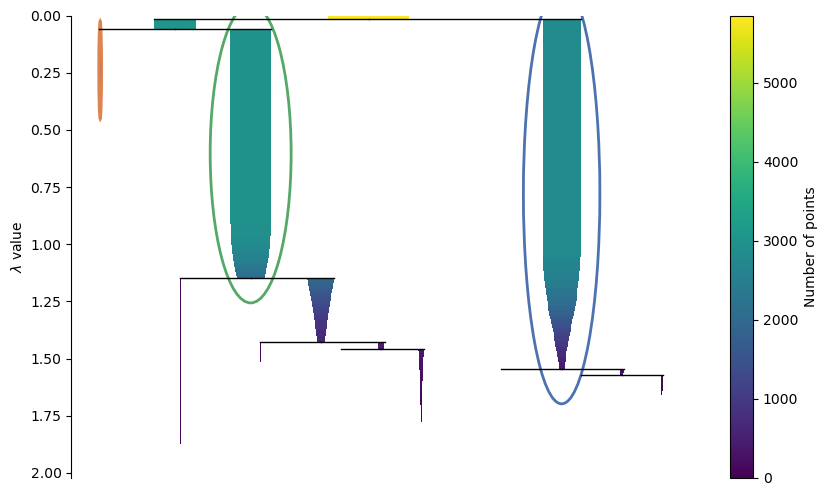

In [340]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
hdbscan_model.condensed_tree_.plot(select_clusters=True, 
                                   selection_palette=sns.color_palette('deep', 30))
plt.show()


In [339]:
# On récupère les labels uniques
unique_labels = set(cluster_labels)

# On compte le nombre de labels, en excluant -1 s'il est présent
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"Nombre de clusters identifiés : {n_clusters}")
print(f"Nombre de points considérés comme du bruit : {n_noise} (sur {len(cluster_labels)} restaurants)")

Nombre de clusters identifiés : 3
Nombre de points considérés comme du bruit : 5 (sur 5852 restaurants)


In [294]:
# Moyenne des probabilités d'appartenance par cluster
df['cluster'] = cluster_labels
df['prob'] = hdbscan_model.probabilities_
print(df.groupby('cluster')['prob'].mean())

cluster
-1     0.000000
 0     0.744859
 1     0.784214
 2     0.935673
 3     0.992914
 4     0.900269
 5     0.982924
 6     0.997926
 7     0.844632
 8     0.907596
 9     0.820518
 10    0.982514
 11    0.938777
 12    0.849321
 13    0.951735
 14    0.762845
Name: prob, dtype: float64


## interpretation des clusters

on commence par attacher les clusters aux textes

In [99]:
textes_restaurant['cluster'] = cluster_labels

In [100]:
textes_restaurant

,business_id,text,cleaned_text_embedding,cluster
0,-0M0b-XhtFagyLmsBtOe8w,Ok so this place is an extremely odd hole in t...,ok so this place is an extremely odd hole in t...,10
1,-0PN_KFPtbnLQZEeb23XiA,Far and away the best Chinese food to order if...,far and away the best food to order if you liv...,1
2,-0TffRSXXIlBYVbb5AwfTg,I went to indieblue a few years ago for happy ...,i went to indieblue a few years ago for happy ...,10
3,-0eUa8TsXFFy0FCxHYmrjg,"We are sitting in an ICU waiting room, several...",we are sitting in an icu waiting room several ...,-1
4,-1B9pP_CrRBJYPICE5WbRA,The food is absolutely amazing. I get food ...,the food is absolutely amazing i get food deli...,4
...,...,...,...,...
5847,zxY4DgtXsVHihSUpsmwamg,This Place has Good Hoagies and the Staff is s...,this place has good hoagies and the staff is s...,6
5848,zy7uNOvpykrq-XlmDY_wHA,"Sadiki's is now Relish, nothing last's over th...",sadiki s is now relish nothing last s over the...,-1
5849,zyMkbavgHASQtqVwaock9A,I've had pretty much everything on the menu an...,i ve had pretty much everything on the menu an...,-1
5850,zz-fcqurtm77bZ_rVvo2Lw,"My love affair with Yumtown began with ""The Jo...",my love affair with yumtown began with the joy...,-1


In [101]:
(textes_restaurant["cluster"] == -1).sum()


3154

ca fait 30% d'outliers, c'est beaucoup j'ai l'impression ? peut etre reduire le nbre de documents minimum par cluster

Le but de cette prochaine etape est de labeliser les clusters. pour cela on va dabord faire un nettoyage des textes plus important que pour le Sbert. En effet sbert comprends le sens total de la phrase, la pou c-TFIDF travailles avec des mots discrimiannt.
Etant donné que nous on ne veut pas avoir des clusters qui se concentrent sur le type de nourriture mais sur l'experience on va enlever les mots relatifs aux plats, pour eviter d'avoir des cluysters de type "chinease food" "indian food" ect 

In [ ]:
import re
import html
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stoplist = set(stopwords.words("english"))
porter = PorterStemmer()


def clean_for_ctfidf(text: str) -> str:
    if not isinstance(text, str):
        return ""

    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)

    tokens = [
        porter.stem(tok)
        for tok in text.split()
        if tok not in stoplist and len(tok) > 2
    ]

    return " ".join(tokens)
textes_restaurant["cleaned_text_ctfidf"] = textes_restaurant["text"].apply(clean_for_ctfidf)

on fait un document avec tous les textes par cluster

In [104]:
df = textes_restaurant.copy()

docs_per_cluster = (
    df[df["cluster"] != -1]
    .groupby("cluster")["cleaned_text_ctfidf"]
    .apply(" ".join)
)


on calcul le c-tf-idf

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# vectorisation
vectorizer = CountVectorizer(
    ngram_range=(1, 3),
    min_df=5,
    stop_words="english"
)

X = vectorizer.fit_transform(docs_per_cluster.values)

# c-TF-IDF
tf = X.toarray()
tf_sum = tf.sum(axis=0)

A = tf.sum(axis=1).mean()

ctfidf = tf * np.log(1 + A / tf_sum)


on extrait les tops mots pas cluster

In [106]:
terms = vectorizer.get_feature_names_out()

top_words = {}

for i, cluster_id in enumerate(docs_per_cluster.index):
    scores = ctfidf[i]
    top_idx = scores.argsort()[::-1][:10]
    top_words[cluster_id] = [(terms[j], scores[j]) for j in top_idx]


In [107]:
for cluster_id, words in top_words.items():
    print(f"\n🟦 Cluster {cluster_id}")
    for word, score in words:
        print(f"  {word:<25} {score:.3f}")



🟦 Cluster 0
  vegan                     9121.134
  food                      4939.191
  good                      3854.357
  place                     3818.523
  order                     3292.073
  tri                       3282.370
  great                     3262.118
  love                      3089.146
  delici                    2997.990
  like                      2837.979

🟦 Cluster 1
  food                      28754.853
  order                     23990.038
  place                     21493.280
  good                      20749.405
  roll                      16997.314
  like                      15843.372
  time                      14950.833
  restaur                   14642.778
  tri                       14642.122
  great                     13963.361

🟦 Cluster 2
  food                      7536.471
  good                      5541.074
  place                     5342.325
  order                     5198.237
  salsa                     4370.295
  great                   